<a href="https://colab.research.google.com/github/ecbme4040/e4040-2022Fall-Project-AHSN-am5964-hsp2122-ska2145/blob/main/Model_Implementation/MobileNet_Vs_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AHSN Project
#### Done by:
Safeyah Alshemali(ska2145) - Hannah Portes(hsp2122) - Aparna Muraleekrishnan(am5964)

#### Based on Paper: 
MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications
[link](https://https://arxiv.org/abs/1704.04861)

#### Authors: 
Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam

Done By: Aparna , Hannah , Safeyah

### Code Libraries

Below is the process of loading the data of Imagenette. This tensorflow dataset has 10 classes, 9469 training samples, and 3925 validation samples.

In [1]:
# Import modules
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import datasets, layers, models
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, Activation , DepthwiseConv2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D,  GlobalAveragePooling2D, AveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

In [2]:
print('tensorflow version:', tf. __version__)


tensorflow version: 2.9.2


### Data Processing

The data set we are using is Tiny ImageNet which is subset of ImageNet dataset of 200 classes. 

In [3]:
# code to get data and unzip - works on colab
## Download the dataset and unzip it 
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2022-12-19 00:22:45--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  50.1MB/s    in 5.5s    

2022-12-19 00:22:51 (43.0 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [4]:
# only for use in google colab - allow colab access to your drive for data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# current structure
#ls

In [6]:
# unzip data file 
!unzip -qq 'tiny-imagenet-200.zip'
!ls

drive  sample_data  tiny-imagenet-200  tiny-imagenet-200.zip


In [13]:
train_datagenerator = ImageDataGenerator(rescale= 1./255,
      rotation_range=30,
      height_shift_range=0.3)

train_data = train_datagenerator.flow_from_directory( r'tiny-imagenet-200/train/', 
                                                     target_size=(224, 224), color_mode='rgb', 
                                                     batch_size=256, class_mode='categorical', 
                                                     shuffle=True, seed=42)

print(type(train_data))
     

Found 100000 images belonging to 200 classes.
<class 'keras.preprocessing.image.DirectoryIterator'>


In [14]:
val_data = pd.read_csv('tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [15]:
valid_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', 
                                                         x_col='File', y_col='Class', target_size=(224, 224),
                                                         color_mode='rgb', class_mode='categorical', batch_size=256, 
                                                         shuffle=True, seed=42)

Found 10000 validated image filenames belonging to 200 classes.


In [16]:
num_classes = train_data[0][1].shape[1]

print('Number of classes: ', num_classes)
print('Number of validation samples: ', val_data.shape[0])

Number of classes:  200
Number of validation samples:  10000


In [17]:
batch_dim = train_data[0][0].shape

print('Batch Size: ', batch_dim[0])
print('Image dimensions: ', batch_dim[1:3])
print('Num Channels Size: ', batch_dim[3])

Batch Size:  256
Image dimensions:  (224, 224)
Num Channels Size:  3


### Data Visualization 

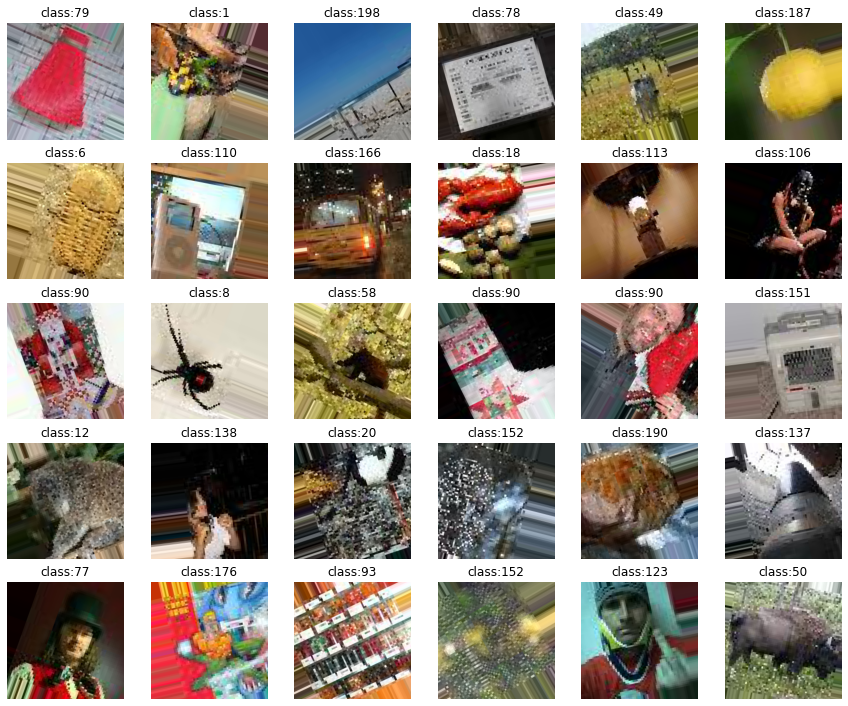

In [18]:
# plot some images to explore the data - each image is labeled by class
x_batch, y_batch = next(train_data)

plt.figure(figsize=(15, 15))

for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.title('class:' + str(np.argmax(y_batch[i])))
    plt.imshow(x_batch[i,:,:])
    plt.axis("off")

### MobileNet Model

Model Creation

In [19]:
def create_MobileNet_model(input_shape, no_classes):
    
    print('layer 1 input', input_shape)

    #first layer (Conv/s2)
    input = Input(shape= input_shape)
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2) ,padding='same', use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    print('layer 2 input', x.shape)
    #second layer (Conv dw/s1) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(64,(1, 1), (1, 1) ,x)

    print('layer 3 input', x.shape)
    #third layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(128,(1, 1), (1, 1) ,x)
    
    
    print('layer 4 input', x.shape)
    #4th layer (Conv dw/s1) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(128,(1, 1), (1, 1) ,x)

    print('layer 5 input', x.shape)
    #5th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(256,(1, 1), (1, 1) ,x)

    print('layer 6 input', x.shape)
    #6th layer (Conv dw/s1) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(256,(1, 1), (1, 1) ,x)

    print('layer 7 input', x.shape)
    #7th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(512,(1, 1), (1, 1) ,x)

    print('layer 8 stack input', x.shape)
    #8thlayer: 5 * (Conv dw/s1) + (Conv dw /s1)
    for _ in range(5):
      x = DepthWiseConv((3,3), (1,1), x)
      x = PointWiseConv(512,(1, 1), (1, 1) ,x)

    print('layer 9 input', x.shape)
    #9th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(1024,(1, 1), (1, 1) ,x)

    print('layer 10 input', x.shape)
    #10th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(1024,(1, 1), (1, 1) ,x)

    print('Avg Pooling input', x.shape)
    #11th layer: Avg Pooling (7*7)
    x = AveragePooling2D(pool_size=(7,7), strides=(1,1))(x)

    print('Flatten input', x.shape)
    #print('Flatten layer input', x.shape)
    #Flatten layer / s1? 
    x = Flatten()(x)

    print('Dense 12 input', x.shape)
    #12th layer : Affine layer
    out = Dense(no_classes,activation='softmax')(x)

    print('out', out.shape)

    model = Model(input, out, name='mobilenet')

    return model    

The Depthwise Separable Convolution layer

In [ ]:
def DepthWiseConv(kernal_size, stride, x):
    result = DepthwiseConv2D(kernal_size, strides=stride , padding='same')(x)
    result = BatchNormalization()(result)
    result = Activation('relu')(result)
    return result

In [ ]:
def PointWiseConv(filters,kernal_size, stride, x):
    result = Conv2D(filters, kernel_size=kernal_size, strides=stride)(x)
    result = BatchNormalization()(result)
    result = Activation('relu')(result)
    return result

Fitting and Training the Model

In [ ]:
MobileNet = create_MobileNet_model((224,224,3),200)
MobileNet.summary()


layer 1 input (224, 224, 3)
layer 2 input (None, 112, 112, 32)
layer 3 input (None, 112, 112, 64)
layer 4 input (None, 56, 56, 128)
layer 5 input (None, 56, 56, 128)
layer 6 input (None, 28, 28, 256)
layer 7 input (None, 28, 28, 256)
layer 8 stack input (None, 14, 14, 512)
layer 9 input (None, 14, 14, 512)
layer 10 input (None, 7, 7, 1024)
Avg Pooling input (None, 7, 7, 1024)
Flatten input (None, 1, 1, 1024)
Dense 12 input (None, 1024)
out (None, 200)
Model: "mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 32)      864       
                                                                 
 batch_normalization_27 (Bat  (None, 112, 112, 32)     128       
 chNormalization)                                              

In [ ]:
MobileNet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
MobileNet.fit(train_data, epochs=15, validation_data=validation_generator, verbose=1)


Epoch 1/15
391/391 [==============================] - 593s 1s/step - loss: 4.4056 - accuracy: 0.0904 - val_loss: 7.5694 - val_accuracy: 0.0050
Epoch 2/15
391/391 [==============================] - 583s 1s/step - loss: 3.4534 - accuracy: 0.2204 - val_loss: 4.0983 - val_accuracy: 0.1719
Epoch 3/15
391/391 [==============================] - 587s 1s/step - loss: 2.9388 - accuracy: 0.3127 - val_loss: 4.6232 - val_accuracy: 0.1592
Epoch 4/15
391/391 [==============================] - 584s 1s/step - loss: 2.5629 - accuracy: 0.3850 - val_loss: 4.5798 - val_accuracy: 0.1859
Epoch 5/15
391/391 [==============================] - 584s 1s/step - loss: 2.2533 - accuracy: 0.4484 - val_loss: 3.2151 - val_accuracy: 0.3217
Epoch 6/15
391/391 [==============================] - 581s 1s/step - loss: 1.9858 - accuracy: 0.5030 - val_loss: 3.4621 - val_accuracy: 0.2880
Epoch 7/15
391/391 [==============================] - 582s 1s/step - loss: 1.7401 - accuracy: 0.5559 - val_loss: 3.1722 - val_accuracy: 0.3237

## CNN Model

Model Creation

In [20]:
def create_CNN_model(input_shape, no_classes):
    
    print('layer 1 input', input_shape)

    #first layer (Conv/s2)
    input = Input(shape= input_shape)
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2) ,padding='same', use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    print('layer 2 input', x.shape)
    #second layer (Conv dw/s1) + (Conv /s1)
    x = Conv2D(64, kernel_size=(3,3), strides=(1,1) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(64,(3,3),(1,1),x)(x)

    print('layer 3 input', x.shape)
    #third layer (Conv dw/s2) + (Conv /s1)
    x = Conv2D(128, kernel_size=(3,3), strides=(2,2) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(128,(3,3), (2,2),x)(x)  
    
    print('layer 4 input', x.shape)
    #4th layer (Conv dw/s1) + (Conv /s1)
    x = Conv2D(128, kernel_size=(3,3), strides=(1,1) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(128,(3,3), (1,1),x)(x)

    print('layer 5 input', x.shape)
    #5th layer (Conv dw/s2) + (Conv /s1)
    x = Conv2D(256, kernel_size=(3,3), strides=(2,2) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(256,(3,3), (2,2),x)(x)

    print('layer 6 input', x.shape)
    #6th layer (Conv dw/s1) + (Conv /s1)
    x = Conv2D(256, kernel_size=(3,3), strides=(1,1) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(256,(3,3), (1,1),x)(x)

    print('layer 7 input', x.shape)
    #7th layer (Conv dw/s2) + (Conv /s1)
    x = Conv2D(512, kernel_size=(3,3), strides=(2,2) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(512,(3,3), (2,2),x)(x)

    print('layer 8 stack input', x.shape)
    #8thlayer: 5 * (Conv dw/s1) + (Conv dw /s1)
    for _ in range(5):
      x = Conv2D(512, kernel_size=(3,3), strides=(1,1) ,padding='same', use_bias=False)(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      #x = standard_Conv(512,(3,3), (1,1),x)(x)
      
    print('layer 9 input', x.shape)
    #9th layer (Conv dw/s2) + (Conv /s1)
    x = Conv2D(1024, kernel_size=(3,3), strides=(2,2) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(1024,(3,3), (2,2),x)(x)

    print('layer 10 input', x.shape)
    #10th layer (Conv dw/s2) + (Conv /s1)
    x = Conv2D(1024, kernel_size=(3,3), strides=(1,1) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(1024,(3,3), (1,1),x)(x)

    print('Avg Pooling input', x.shape)
    #11th layer: Avg Pooling (7*7)
    x = AveragePooling2D(pool_size=(7,7), strides=(1,1))(x)

    print('Flatten input', x.shape)
    #print('Flatten layer input', x.shape)
    #Flatten layer / s1? 
    x = Flatten()(x)

    print('Dense 12 input', x.shape)
    #12th layer : Affine layer
    out = Dense(no_classes,activation='softmax')(x)

    print('out', out.shape)

    model = Model(input, out, name='CNN')

    return model    

Standard Convolution Layer

In [21]:
def standard_Conv(filter,kernal_size, stride, x):
  x = Conv2D(filter, kernel_size=kernal_size, strides=stride ,padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [ ]:
CNN_Model = create_CNN_model((224,224,3),200)
CNN_Model.summary()


Fitting and Training The Model

We cannot fit and train the model with image size 224 without the colab or virtual machine crashing.

In [ ]:
CNN_Model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
CNN_Model.fit(train_data, epochs=15, validation_data=validation_generator, verbose=1)